In [2]:
import torch
from torchvision import datasets, transforms
import numpy as np
from os.path  import join
from tqdm.notebook import tqdm


%matplotlib inline
import matplotlib.pyplot as plt
from helpers import *
from lenslets import *
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

import sys
sys.path.append('..')
from extended_fov_helpers import * 

from skimage.transform import rescale, resize

%load_ext autoreload
%autoreload 2
%matplotlib inline

sys.path.append('../recon')
import recon.load_scripts_extended as loading
from recon.helper_fns_extended import *

# Choose CPU or GPU here:
%run ../recon/fista_spectral_cupy.py CPU #GPU


device =  CPU , using CPU and numpy


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # converts RGB -> 1 channel
    transforms.ToTensor(),                         # converts to [0,1] float tensor
])
train_dataset = datasets.CIFAR10(root='./data/CIFAR10', train=True, download=False, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data/CIFAR10', train=False, download=False, transform=transform)

x_train = torch.stack([img for img, _ in train_dataset])  # shape: [60000, 1, 28, 28]
x_test  = torch.stack([img for img, _ in test_dataset])   # shape: [10000, 1, 28, 28]

# Remove channel dimension if needed
x_train = x_train.squeeze(1)  # [60000, 28, 28]
x_test  = x_test.squeeze(1)   # [10000, 28, 28]

# Normalize to 0-1 (already 0-1 from ToTensor, but ensures max=1)
x_train = x_train / x_train.max()
x_test  = x_test  / x_test.max()

num_tiles = 100
cifar_tiles = make_image_tiles_torch(x_train, grid_size=3, num_grids=num_tiles).numpy()
plt.imshow(cifar_tiles[1], cmap='gray')
cifar_tiles.shape

In [3]:
print(x_train.shape)

torch.Size([50000, 32, 32])


In [4]:
lenslets = np.array([load_single_lens_uniform(), load_two_lens_uniform(), load_three_lens_uniform(), load_four_lens_uniform(), load_five_lens_uniform(), load_six_lens_uniform(), load_seven_lens_uniform(), load_eight_lens_uniform(), load_nine_lens_uniform()])


In [ ]:
total_mse_lst = []
total_psnr_lst = []
total_ssim_lst = []

for (i, lenslet) in enumerate(tqdm(lenslets, desc="Lenslets")):
    psf_name = 'lenslet_{}'.format(i)
    mse_lst = []
    psnr_lst = []
    ssim_lst = []
    for (j, tile_img) in enumerate(tqdm(cifar_tiles, desc="Tiles", leave=False)):
        lens_path = './cifar10/measurements/lens_{}/'.format(i)
        if not os.path.exists(lens_path):
            os.mkdir(lens_path)
        name = 'img_{}'.format(j)

        conv_img, img_save_path, f_name = forward(tile_img, lenslet, psf_name=psf_name, name=name, gray=True, crop=False, save_path=lens_path)
        
        ## RECON
        results_path = './cifar10/results/lens_{}/'.format(i)
        if not os.path.exists(results_path):
            os.mkdir(results_path)
        
        psf, img, mask = preprocess('./psfs/lenslet_{}.npy'.format(i), img_save_path, f=1, gray_image=False)
        ## Recon Parameters
        fista = fista_spectral_numpy(psf[:,:,1:2], mask[:,:,1:2], gray=False) # green channel only

        # set FISTA parameters
        fista.iters = 100
        fista.prox_method = 'tv'  
        fista.tv_lambda  = 1e-2 #1e-3, 1e-2, 1e-1
        fista.tv_lambdaw = 0.01
        fista.print_every = 100

        ## Run FISTA
        out_img = fista.run(img)

        ## Display Results
        cropped = out_img[0][0]
        uncropped = out_img[0][1]

        cropped_name = f'cropped_{f_name}'
        uncropped_name = f'uncropped_{f_name}'

        fig = plt.figure()
        plt.imshow(preplot(cropped))
        plt.axis('off') 
        plt.imsave(results_path + cropped_name + '.png', preplot(cropped))


        plt.figure()
        plt.imshow(preplot(uncropped))
        plt.axis('off') 
        plt.imsave(results_path + uncropped_name + '.png', preplot(uncropped))

        np.save(results_path + cropped_name + '.npy', cropped)
        np.save(results_path + uncropped_name + '.npy', uncropped)

        uncropped = uncropped[:, :, 0] 
        print(np.min(uncropped), np.max(uncropped))
        # uncropped = np.clip(uncropped/ np.max(uncropped), 0, 1)
        uncropped[uncropped < 0] = 0

        ### COMPUTE METRICS
        mse_lst.append(mean_squared_error(tile_img, uncropped))
        psnr_lst.append(peak_signal_noise_ratio(tile_img, uncropped, data_range=1))
        ssim_lst.append(structural_similarity(tile_img, uncropped, data_range=1))

    total_mse_lst.append(mse_lst)
    total_psnr_lst.append(psnr_lst)
    total_ssim_lst.append(ssim_lst)

np.save('./cifar10/results/' + 'ssim-test.npy', np.array(total_ssim_lst))
np.save('./cifar10/results/' + 'psnr-test.npy', np.array(total_psnr_lst))
np.save('./cifar10/results/' + 'mse-test.npy', np.array(total_mse_lst))

In [8]:
total_mse_lst = np.array(total_mse_lst)
total_psnr_lst = np.array(total_psnr_lst)
total_ssim_lst = np.array(total_ssim_lst)

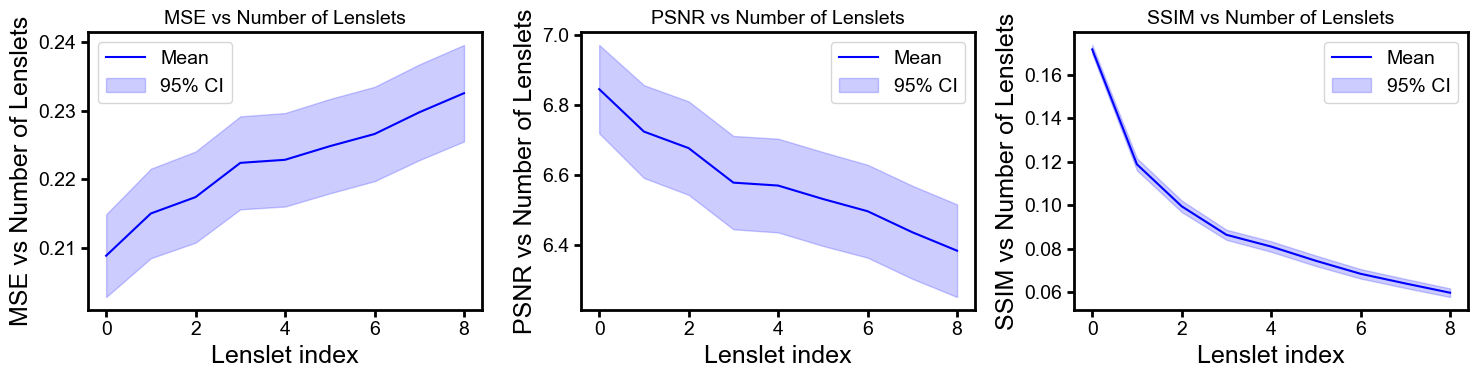

In [9]:
# Example usage:
metrics = [total_mse_lst, total_psnr_lst, total_ssim_lst]
names = ["MSE vs Number of Lenslets", "PSNR vs Number of Lenslets", "SSIM vs Number of Lenslets"]

plot_metrics_with_ci(metrics, names)

In [ ]:
# Lenslet indices to plot
lenslet_indices = list(range(9))  # [0, 1, 2, ..., 8]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()  # Flatten so we can index with a single loop

for ax, lens_idx in zip(axes, lenslet_indices):
    img_path = f'./cifar10/results/lens_{lens_idx}/uncropped_img_99-lenslet_{lens_idx}-measurement.png'
    img = plt.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Lenslet {lens_idx}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
tv_range = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
tv_total_mse_lst = []
tv_total_psnr_lst = []
tv_total_ssim_lst = []
for (i, lenslet) in enumerate(tqdm(lenslets, desc="Lenslets")):
    psf_name = 'lenslet_{}'.format(i)
    lens_path = './cifar10/measurements/lens_{}/'.format(i)
    
    tv_mse_lst = []
    tv_psnr_lst = []
    tv_ssim_lst = []

    for tv_lam in tqdm(tv_range, desc=f"TV Sweep (Lenslet {i})", leave=False):
        mse_lst = []
        psnr_lst = []
        ssim_lst = []
        for (j, tile_img) in enumerate(tqdm(cifar_tiles, desc="Tiles", leave=False)):
            results_path = './cifar10/tv_sweep/lens_{}/tv_{}/'.format(i, round(tv_lam, 2))

            if not os.path.exists(results_path):
                os.mkdir(results_path)

            f_name = 'img_{}-lenslet_{}-measurement'.format(j, i)
            measurement_path = os.path.join(lens_path, f_name + '.npy')

            psf, img, mask = preprocess('./psfs/lenslet_{}.npy'.format(i), measurement_path, f=1, gray_image=False)
            ## Recon Parameters
            fista = fista_spectral_numpy(psf[:,:,1:2], mask[:,:,1:2], gray=False) # green channel only

            # set FISTA parameters
            fista.iters = 100
            fista.prox_method = 'tv'  
            fista.tv_lambda  = tv_lam
            fista.tv_lambdaw = 0.01
            fista.print_every = 100

            ## Run FISTA
            out_img = fista.run(img)

            ## Display Results
            cropped = out_img[0][0]
            uncropped = out_img[0][1]

            cropped_name = f'cropped_{f_name}'
            uncropped_name = f'uncropped_{f_name}'

            plt.imsave(results_path + uncropped_name + '.png', preplot(uncropped))
            
            uncropped = uncropped[:, :, 0] 
            uncropped = np.clip(uncropped, 0, 1)

            ### COMPUTE METRICS
            mse_lst.append(mean_squared_error(tile_img, uncropped))
            psnr_lst.append(peak_signal_noise_ratio(tile_img, uncropped, data_range=1))
            ssim_lst.append(structural_similarity(tile_img, uncropped, data_range=1))
        
        tv_mse_lst.append(mse_lst)
        tv_psnr_lst.append(psnr_lst)
        tv_ssim_lst.append(ssim_lst)
    
    tv_total_mse_lst.append(tv_mse_lst)
    tv_total_psnr_lst.append(tv_psnr_lst)
    tv_total_ssim_lst.append(tv_ssim_lst)

np.save('./cifar10/tv_sweep/' + 'ssim.npy', np.array(tv_total_mse_lst))
np.save('./cifar10/tv_sweep/' + 'psnr.npy', np.array(tv_total_psnr_lst))
np.save('./cifar10/tv_sweep/' + 'mse.npy', np.array(tv_total_ssim_lst))

In [ ]:
tv_total_mse_lst = np.array(tv_total_mse_lst)
tv_total_psnr_lst = np.array(tv_total_psnr_lst)
tv_total_ssim_lst = np.array(tv_total_ssim_lst)
metrics = [tv_total_mse_lst, tv_total_psnr_lst, tv_total_ssim_lst]
# Call for each metric
plot_metric_grid(tv_total_mse_lst, tv_range, ylabel="MSE",  title_prefix="MSE vs TV")
plot_metric_grid(tv_total_psnr_lst, tv_range, ylabel="PSNR", title_prefix="PSNR vs TV")
plot_metric_grid(tv_total_ssim_lst, tv_range, ylabel="SSIM", title_prefix="SSIM vs TV")